
# Este modelo de red entrena un BiLSTM + CRF para la clasificación de NER sobre el corpus Conll2002. Este modelo tiene como entrada a la red la enterización del conjunto X de entrenamiento y la enterización y categorización  de los vectores de etiquetas. En este modelo no hay matriz de embedding.

In [ ]:
!pip install seqeval

In [ ]:
try:
    import seqeval
except ModuleNotFoundError as err:
    !pip install seqeval

In [ ]:
!pip install tensorflow-addons
!pip install crf


In [ ]:

import tensorflow as tf
#matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/PLN/tarea 3/sources') # Reemplazar ruta


In [ ]:
!pip install crfta
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from itertools import islice

#from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as eskclarep
#from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
#from seqeval.metrics import classification_report as seqclarep
from sklearn.preprocessing import LabelBinarizer
from itertools import chain

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Concatenate, Lambda, Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer, Activation, Flatten
from tensorflow.keras.optimizers import Adam, schedules
#from crfta import CRF as crf4
from utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

from IPython.core.display import display, HTML

import datetime, os
import random



# Instalación del paquete nltk

In [ ]:
import nltk
nltk.download('conll2002')
nltk.corpus.conll2002.fileids()

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [ ]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
eval_sents = list(nltk.corpus.conll2002.iob_sents('esp.testa'))
print(len(train_sents),len(max(train_sents,key=len)))
print(len(test_sents),len(max(test_sents,key=len)))
print(len(eval_sents),len(max(eval_sents,key=len)))

8323 1238
1517 202
1915 141
CPU times: user 2.07 s, sys: 97.5 ms, total: 2.16 s
Wall time: 2.15 s


In [ ]:
print(train_sents[0])

[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


# PARTE  1. PREPROCESAMIENTO DE LOS DATOS

In [ ]:
def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [ ]:
sent2tokens(train_sents[0])[0]
sent2labels(train_sents[0])[0]

'B-LOC'

In [ ]:
%%time
X_train = [sent2tokens(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2tokens(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

X_eval = [sent2tokens(s) for s in eval_sents]
y_eval = [sent2labels(s) for s in eval_sents]

CPU times: user 115 ms, sys: 2.88 ms, total: 117 ms
Wall time: 117 ms


In [ ]:
print(X_train[2])
print(y_train[2]) #B-LOC

['El', 'Abogado', 'General', 'del', 'Estado', ',', 'Daryl', 'Williams', ',', 'subrayó', 'hoy', 'la', 'necesidad', 'de', 'tomar', 'medidas', 'para', 'proteger', 'al', 'sistema', 'judicial', 'australiano', 'frente', 'a', 'una', 'página', 'de', 'internet', 'que', 'imposibilita', 'el', 'cumplimiento', 'de', 'los', 'principios', 'básicos', 'de', 'la', 'Ley', '.']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O']


In [ ]:
import numpy as np

words, tagsss = set([]), set([])

for s in (X_train + X_eval + X_test):
    for w in s:
        words.add(w.lower())

for ts in (y_train + y_eval + y_test):
    for t in ts:
        tagsss.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs

tag2index = {t: i + 2 for i, t in enumerate(list(tagsss))}
tag2index['-PAD-'] = 0  # The special value used to padding
tag2index['-OOV-'] = 1  # The special value used to padding

print (len(word2index))
print (len(tag2index))
print(tag2index)


print(tagsss)

28384
11
{'I-MISC': 2, 'I-PER': 3, 'B-PER': 4, 'B-MISC': 5, 'O': 6, 'I-ORG': 7, 'I-LOC': 8, 'B-LOC': 9, 'B-ORG': 10, '-PAD-': 0, '-OOV-': 1}
{'I-MISC', 'I-PER', 'B-PER', 'B-MISC', 'O', 'I-ORG', 'I-LOC', 'B-LOC', 'B-ORG'}


In [ ]:
train_sentences_X, eval_sentences_X, test_sentences_X, train_tags_y, eval_tags_y, test_tags_y = [], [], [], [], [], []

for s in X_train:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    train_sentences_X.append(s_int)

for s in X_eval:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    eval_sentences_X.append(s_int)

for s in X_test:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    test_sentences_X.append(s_int)

for s in y_train:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])

    train_tags_y.append(s_int)

for s in y_eval:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])

    eval_tags_y.append(s_int)

for s in y_test:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])

    test_tags_y.append(s_int)


# Las matrices de los tags son de números indexados pequeños porque solo son 11 tags.  ({ORG, LOC, PER}  X IOB)

In [ ]:
print("Longitudes de las Matrices:")
print(len(train_sentences_X))
print(len(eval_sentences_X))
print(len( test_sentences_X))
print(len(train_tags_y))
print(len(eval_tags_y))
print(len(test_tags_y))

print("\nMuestra de Datos presentes en las Matrices con las transformaciones:\n")


print(train_sentences_X[0])
print(eval_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(eval_tags_y[0])
print(test_tags_y[0])


Longitudes de las Matrices:
8323
1915
1517
8323
1915
1517

Muestra de Datos presentes en las Matrices con las transformaciones:

[19760, 17762, 15470, 19668, 24359, 1594, 7291, 17762, 13891, 19668, 2862]
[6913, 17446, 17762, 3943, 19668, 24359, 13512, 7291, 17762, 22768, 19668, 2862]
[20152, 20604, 24359, 13512, 7291, 17762, 22768, 19668, 2862]
[9, 6, 9, 6, 6, 6, 6, 6, 10, 6, 6]
[9, 8, 6, 9, 6, 6, 6, 6, 6, 10, 6, 6]
[9, 8, 6, 6, 6, 6, 10, 6, 6]


# Se procede a Normalizar las matrices con la longitud de la columna=MAX_LENGTH1 para que todas contengan el mismo numero de columnas, con la longitud máxima de palabras encontradas anteriormente y se agregan ceros a la derecha en las posiciones que hacen falta en el vector.

In [ ]:
# MAX_LENGTH=202
MAX_LENGTH=50
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
eval_sentences_X = pad_sequences(eval_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
eval_tags_y = pad_sequences(eval_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

print(train_sentences_X[0])
print(train_sentences_X.shape)
print(eval_sentences_X[0])
print(eval_sentences_X.shape)
print(test_sentences_X[0])
print(test_sentences_X.shape)
print(train_tags_y[0])
print(train_tags_y.shape)
print(eval_tags_y[0])
print(eval_tags_y.shape)
print(test_tags_y[0])
print(test_tags_y.shape)



[19760 17762 15470 19668 24359  1594  7291 17762 13891 19668  2862     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
(8323, 50)
[ 6913 17446 17762  3943 19668 24359 13512  7291 17762 22768 19668  2862
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
(1915, 50)
[20152 20604 24359 13512  7291 17762 22768 19668  2862     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
(1517, 50)
[ 9  6  9  6  6  6  6  6 10  6  6  0  0  0  0  0 

In [ ]:
def to_categoricals(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [ ]:


def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

# Se realiza la categorización one-hot de las etiquetas o labels de entrenamiento, testeo y validación

In [ ]:
cat_train_tags_y = to_categoricals(train_tags_y, len(tag2index))
cat_eval_tags_y  = to_categoricals(eval_tags_y, len(tag2index))
cat_test_tags_y  = to_categoricals(test_tags_y, len(tag2index))

print(cat_train_tags_y[1])
print(len(cat_train_tags_y))
print(cat_train_tags_y.shape)
print(len(cat_test_tags_y))

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.

# PARTE 2. ENTRENAMIENTO DEL MODELO DE RED.

# Carga del embeddings de DGT

In [ ]:
from google.colab import drive

In [ ]:
from utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df

EMBED_DIM=300
# file = '/content/drive/MyDrive/PLN/tarea 3/sources/word2vec_skip-gram_model_300.txt' # Reemplazar ruta
# file = '/content/drive/MyDrive/PLN/tarea 3/sources/Viafara_Cadena_Velasco_FastText.txt'# Reemplazar ruta
file = '/content/drive/MyDrive/PLN/tarea 3/sources/Viafara_Cadena_Velasco_Word2Vec.txt' # Reemplazar ruta
embedding_matrix = bme(file, len(word2index), EMBED_DIM, word2index)

Cargando archivo...


0it [00:00, ?it/s]

Encontrado 231865 Word Vectors.


  0%|          | 0/28384 [00:00<?, ?it/s]

Convertidos: 17654 Tokens | Perdidos: 10730 Tokens


# 2. MODELO DE LA RED NEURONAL RECURSIVA (BILSTM+ CRF)
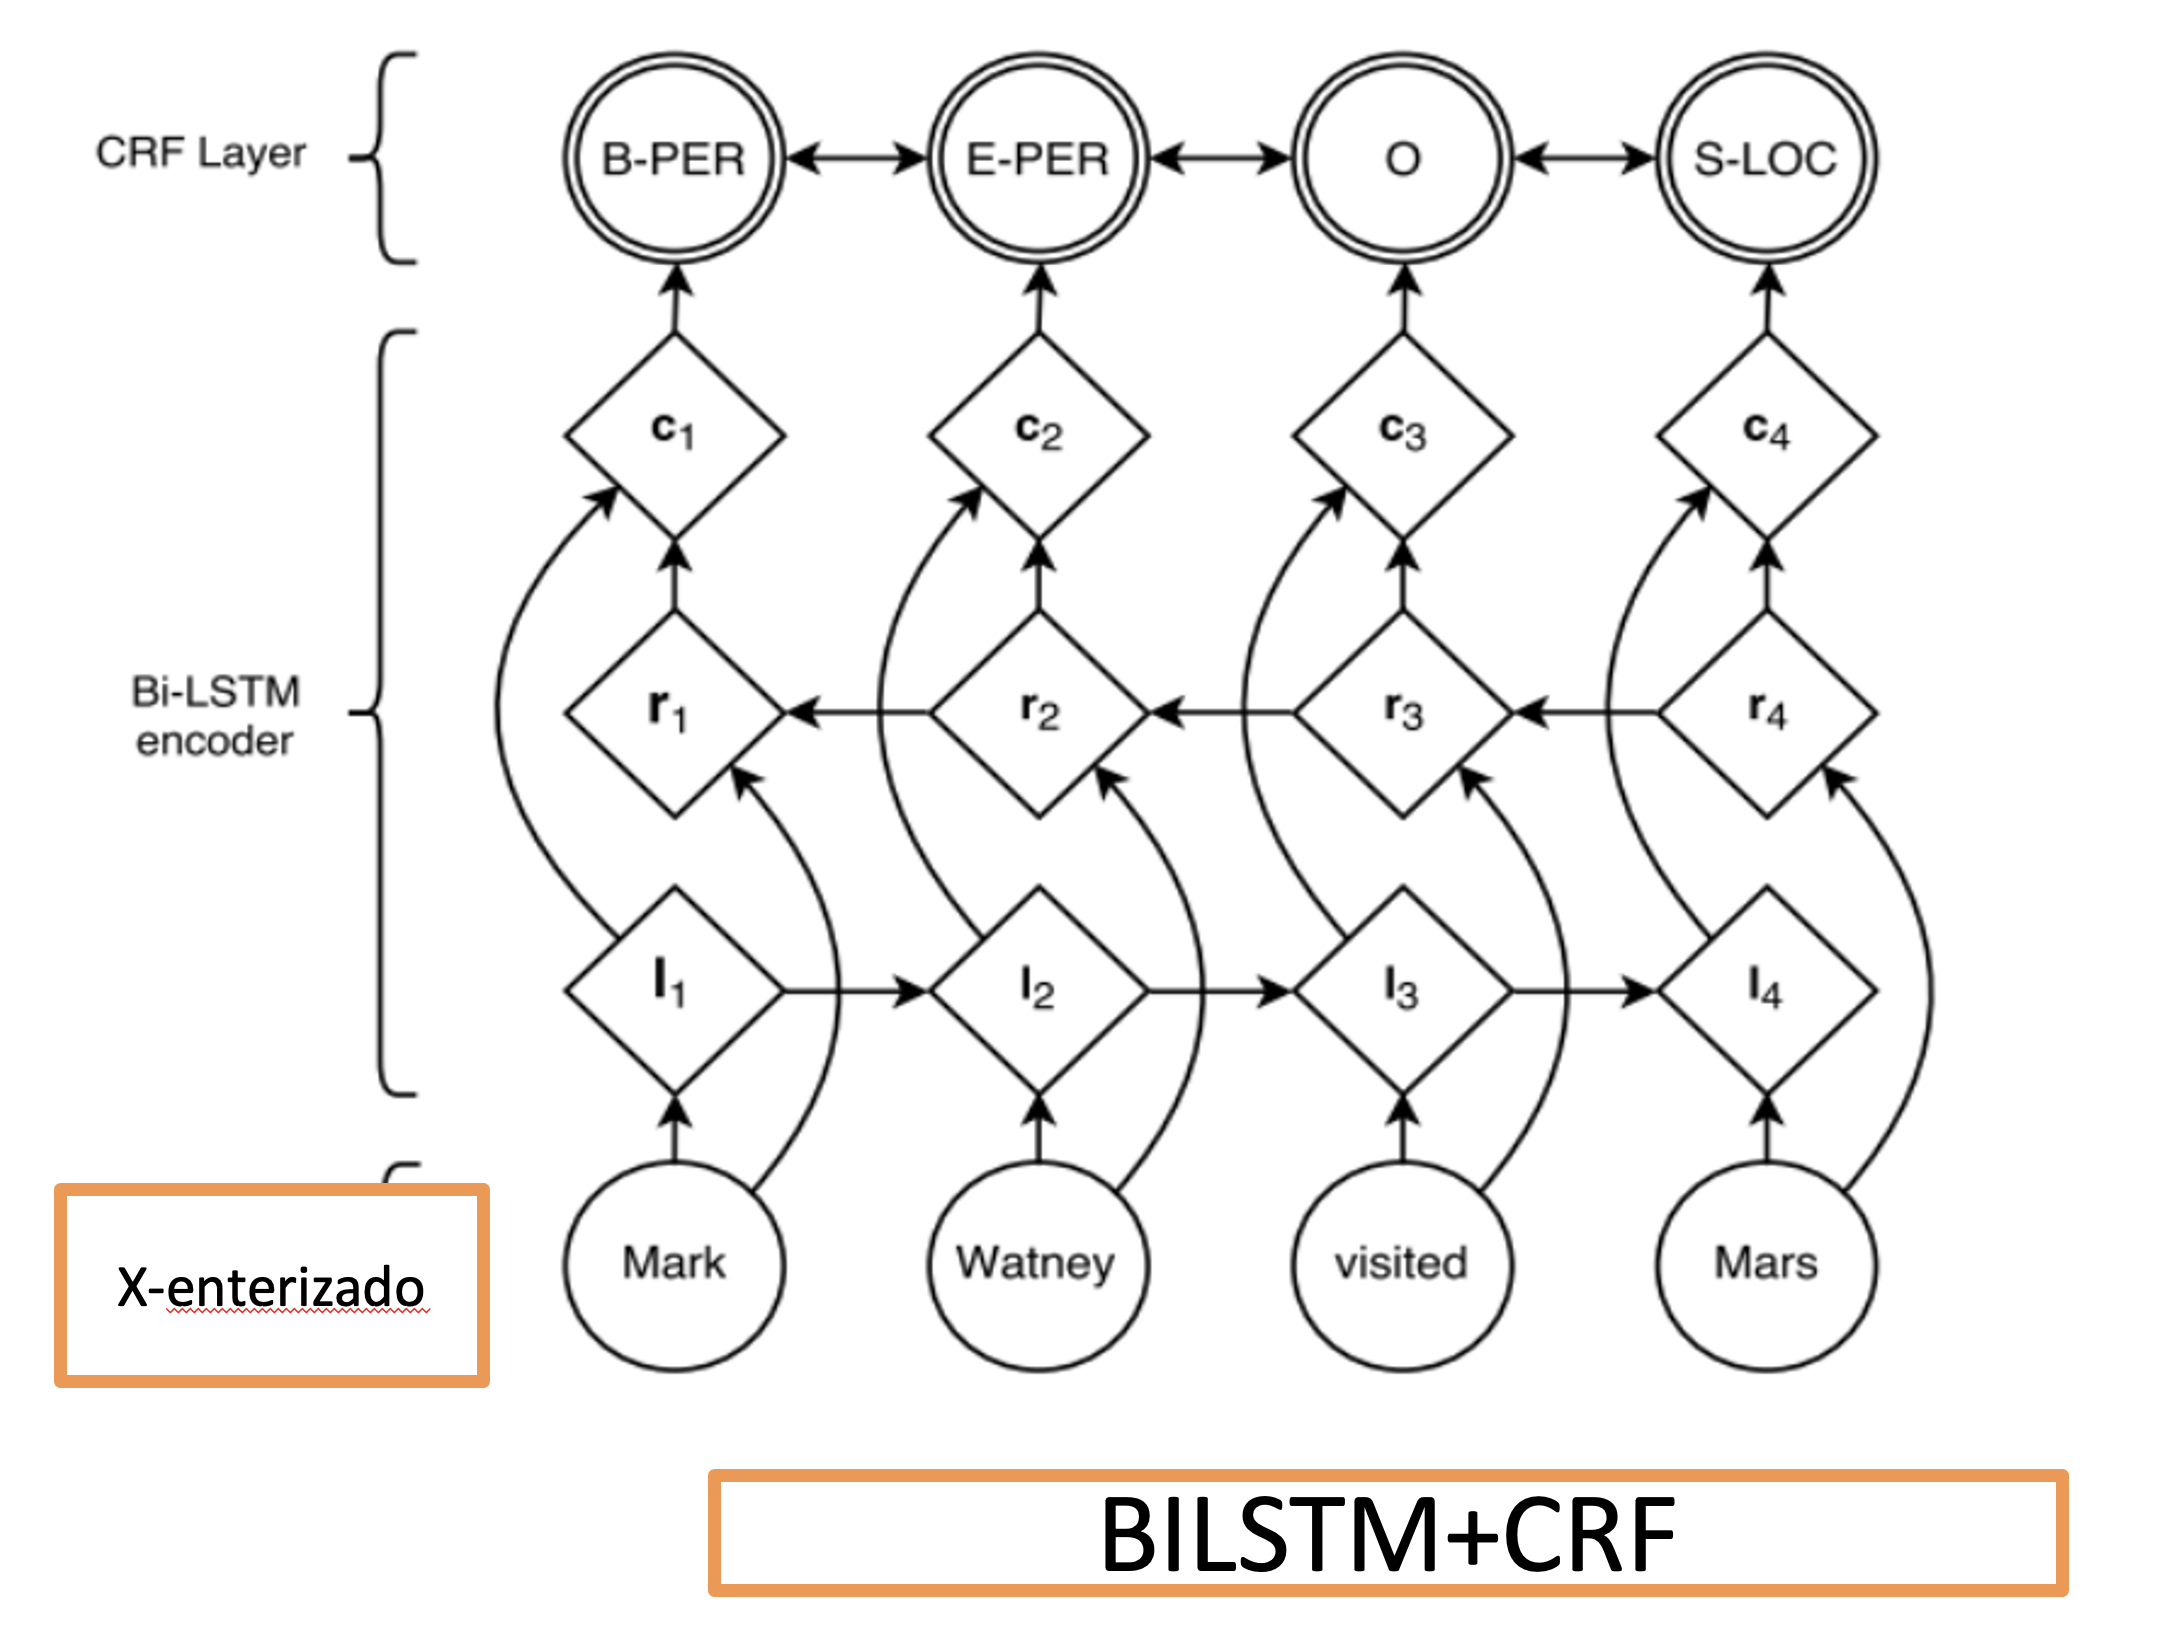

#  Modelo matématico
# Aqui  se define el modelo matémático de la  máquina de aprendizaje que en este caso en una red neuronal recursiva RNN. Específicamente es un Bilstm que  es un Lstm en dos direcciones  y un CRF  para mejorar la distribución probabilística producto de la  red neunoral. En esta red de prueba una estructura de Masking para mejorar las distribuciones probabilídticas. En pocas palabras cumple la función de un distributed. Esta red neuronal tiene una entrada **input = Input(shape=(MAX_LENGTH,))**  esta entrada tiene la longitud de la máxima sentencia  que es 202. Luego se define la matriz de embedding que es una vectorización de palabras usando Word2vec. Esta es una matriz que se vuelve de tres dimensiones 28384 X 202 X 300 y cuando se tiene embedding de palabras se llena son los pesos de la matriz preentrenada, ya sea de word2vec, fasttext o glove. También se pueden concatenar matrices de embedding de otras características lingúísticas como el POS, lema, ect. Luego viene la

In [ ]:
from tf2crf import CRF as crf6
from mwrapper import ModelWithCRFLoss, ModelWithCRFLossDSCLoss
from utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df
from tensorflow.keras.layers import Concatenate, Lambda, Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer, Activation, Flatten, Masking
from tensorflow.keras.optimizers import Adam, schedules
input = Input(shape=(MAX_LENGTH,))
word_embedding_size = 300
EMBED_DIM=300
# Embedding Layer
model = Embedding(input_dim=len(word2index),
                weights=[embedding_matrix],
                output_dim=word_embedding_size,
                input_length=MAX_LENGTH,
                mask_zero=False)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=50,
                     return_sequences=True,
                     dropout=0.5,
                     recurrent_dropout=0.5))(model)

model  = Dropout(0.5, name='dropout_lstm')(model)
model  = Dense(units=EMBED_DIM * 2, activation='relu')(model)
model  = Dense(units=len(tag2index), activation='relu')(model)

model  = Masking(mask_value=0.,input_shape=(MAX_LENGTH, len(tag2index)))(model)


crf = crf6(units=len(tag2index), name="ner_crf")
predictions = crf(model)

base_model = Model(inputs=input, outputs=predictions)
model = ModelWithCRFLoss(base_model, sparse_target=True)

model.compile(optimizer='adam')
#model.summary()

In [ ]:
history= model.fit(train_sentences_X, cat_train_tags_y,
                       validation_data=(eval_sentences_X, cat_eval_tags_y),
                       batch_size=128,
                       epochs=50,
                       verbose=2)

Epoch 1/50
66/66 - 85s - loss: 45.0304 - accuracy: 0.7472 - val_loss_val: 16.8169 - val_val_accuracy: 0.9219 - 85s/epoch - 1s/step
Epoch 2/50
66/66 - 71s - loss: 15.1667 - accuracy: 0.9264 - val_loss_val: 13.5486 - val_val_accuracy: 0.9262 - 71s/epoch - 1s/step
Epoch 3/50
66/66 - 69s - loss: 11.7494 - accuracy: 0.9318 - val_loss_val: 11.3216 - val_val_accuracy: 0.9336 - 69s/epoch - 1s/step
Epoch 4/50
66/66 - 73s - loss: 9.3830 - accuracy: 0.9450 - val_loss_val: 10.1099 - val_val_accuracy: 0.9416 - 73s/epoch - 1s/step
Epoch 5/50
66/66 - 67s - loss: 7.7735 - accuracy: 0.9540 - val_loss_val: 9.5384 - val_val_accuracy: 0.9449 - 67s/epoch - 1s/step
Epoch 6/50
66/66 - 69s - loss: 6.7545 - accuracy: 0.9585 - val_loss_val: 8.8012 - val_val_accuracy: 0.9481 - 69s/epoch - 1s/step
Epoch 7/50
66/66 - 64s - loss: 6.0555 - accuracy: 0.9620 - val_loss_val: 8.4922 - val_val_accuracy: 0.9505 - 64s/epoch - 976ms/step
Epoch 8/50
66/66 - 68s - loss: 5.2746 - accuracy: 0.9654 - val_loss_val: 8.3904 - val_v

In [ ]:
print(tag2index)
print(test_sentences_X)
y_pred= model.predict(test_sentences_X)
print(y_pred.shape)
print(y_pred)

{'I-MISC': 2, 'I-PER': 3, 'B-PER': 4, 'B-MISC': 5, 'O': 6, 'I-ORG': 7, 'I-LOC': 8, 'B-LOC': 9, 'B-ORG': 10, '-PAD-': 0, '-OOV-': 1}
[[20152 20604 24359 ...     0     0     0]
 [24836     0     0 ...     0     0     0]
 [26289 20502  5063 ...  2862     0     0]
 ...
 [20152  1615  4427 ... 11781  2862     0]
 [ 3740 19133 27728 ...     0     0     0]
 [20152  8570 15242 ...     0     0     0]]
48/48 [==============================] - 7s 120ms/step
(1517, 50)
[[9 8 6 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [6 6 6 ... 6 0 0]
 ...
 [6 9 6 ... 6 6 0]
 [6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]]


In [ ]:
from utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df
index2tag = {i: t for t, i in tag2index.items()}
print(index2tag)
y1_pred = logits_to_tokens(y_pred, index2tag)
print(y1_pred[10])

{2: 'I-MISC', 3: 'I-PER', 4: 'B-PER', 5: 'B-MISC', 6: 'O', 7: 'I-ORG', 8: 'I-LOC', 9: 'B-LOC', 10: 'B-ORG', 0: '-PAD-', 1: '-OOV-'}
['O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-']


In [ ]:
#print(Y_test[4])
print(test_tags_y.shape)

(1517, 50)


In [ ]:
from utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df
index2tag = {i: t for t, i in tag2index.items()}
print(index2tag)
y1_true = logits_to_tokens(test_tags_y, index2tag)
print(y1_true[10])

{2: 'I-MISC', 3: 'I-PER', 4: 'B-PER', 5: 'B-MISC', 6: 'O', 7: 'I-ORG', 8: 'I-LOC', 9: 'B-LOC', 10: 'B-ORG', 0: '-PAD-', 1: '-OOV-'}
['O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-']


In [ ]:
#hh1 = seqclarep(results['Expected'], results['Predicted'])
#print('\nclassification_report:\n', hh1)
from seqeval.metrics import classification_report as seqclarep
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
print("precision: {:.1%}".format(precision_score(y1_true, y1_pred)))
print("   recall: {:.1%}".format(recall_score(y1_true,    y1_pred)))
print(" accuracy: {:.1%}".format(accuracy_score(y1_true,  y1_pred)))
print(" F1-score: {:.1%}".format(f1_score(y1_true,        y1_pred)))

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: -PAD- seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 71.8%
   recall: 63.4%
 accuracy: 96.6%
 F1-score: 67.3%


In [ ]:
import pandas as pd
li1 = sum(y1_true, [])
li2 = sum(y1_pred, [])

results = pd.DataFrame(columns=['Expected', 'Predicted'])

results['Expected'] = li1
results['Predicted'] = li2

In [ ]:
from sklearn.metrics import classification_report as eskclarep
report = eskclarep(results['Expected'], results['Predicted'])
#print('\nclassification_report:\n', report)

print(report_to_df(report))

  Class Name precision recall f1-score support
0      -PAD-      1.00   1.00     1.00   27357
1      B-LOC      0.79   0.69     0.74    1023
2     B-MISC      0.52   0.36     0.43     312
3      B-ORG      0.78   0.73     0.76    1292
4      B-PER      0.80   0.68     0.74     636
5      I-LOC      0.82   0.49     0.61     311
6     I-MISC      0.57   0.32     0.41     536
7      I-ORG      0.77   0.58     0.66     993
8      I-PER      0.88   0.76     0.82     560
9          O      0.97   0.99     0.98   42830


In [ ]:
test_samples1 = [
    "James Rodriguez es el jugador colombiano más importante con Radamel Falcao.".split(),
    " Jugadores de la selección Colombia que juegan en el Reino Unido".split()
]
#print(max(test_samples))
print(test_samples1)

[['James', 'Rodriguez', 'es', 'el', 'jugador', 'colombiano', 'más', 'importante', 'con', 'Radamel', 'Falcao.'], ['Jugadores', 'de', 'la', 'selección', 'Colombia', 'que', 'juegan', 'en', 'el', 'Reino', 'Unido']]


In [ ]:
test_samples = [
    "La federación Nacional de cafeteros de Colombia es dirigida por Horacio Sánchez".split(),
    " y se ubica en las ciudades de  Cali y Medellín con el instituto colombiano del café ".split()
]
#print(max(test_samples))
print(test_samples)
from seqeval.metrics import classification_report as seqclarep
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
print("precision: {:.1%}".format(precision_score(test)))
print("   recall: {:.1%}".format(recall_score(y1_true,    y1_pred)))
print(" accuracy: {:.1%}".format(accuracy_score(y1_true,  y1_pred)))
print(" F1-score: {:.1%}".format(f1_score(y1_true,        y1_pred)))

[['La', 'federación', 'Nacional', 'de', 'cafeteros', 'de', 'Colombia', 'es', 'dirigida', 'por', 'Horacio', 'Sánchez'], ['y', 'se', 'ubica', 'en', 'las', 'ciudades', 'de', 'Cali', 'y', 'Medellín', 'con', 'el', 'instituto', 'colombiano', 'del', 'café']]


In [ ]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)

test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)
print(test_samples_X.shape)

[[20152 14511  6945 22704 13794 22704  9129  3732  9748  3396     1 20338
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [25576 21744 18743 23884 26289  6394 22704 11821 25576     1 15427 26663
   7637 13064 25220   640     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]
(2, 50)


In [ ]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

1/1 [==============================] - 0s 40ms/step
[[ 6 10  7  7  7  7  7  6  6  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]] (2, 50)


In [ ]:
#print(len(predictions))
log_tokens = logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})
print(log_tokens)

[['O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-']]


In [ ]:
!pip install tabulate
from tabulate import tabulate

heads1 = test_samples[0]
body1 = [log_tokens[0][:len(test_samples[0])]]

heads2 = test_samples[1]
body2 = [log_tokens[1][:len(test_samples[1])]]

print(tabulate(body1, headers=heads1))

print ("\n")

print(tabulate(body2, headers=heads2))


## postagging Freeling 4.1

## El      hombre   bajo     corre    bajo  el      puente   con  bajo  índice   de  adrenalina  .
## DA0MS0  NCMS000  AQ0MS00  VMIP3S0  SP    DA0MS0  NCMS000  SP   SP    NCMS000  SP  NCFS000     Fp


## pos tagger Stanford NLP

## El      hombre   bajo     corre    bajo  el      puente   con    bajo   índice  de    adrenalina  .
## da0000  nc0s000  aq0000   vmip000  sp000 da0000  nc0s000  sp000  aq0000 nc0s000 sp000 nc0s000     fp

La    federación    Nacional    de     cafeteros    de     Colombia    es    dirigida    por    Horacio    Sánchez
----  ------------  ----------  -----  -----------  -----  ----------  ----  ----------  -----  ---------  ---------
O     B-ORG         I-ORG       I-ORG  I-ORG        I-ORG  I-ORG       O     O           O      -PAD-      -PAD-


y    se    ubica    en    las    ciudades    de    Cali    y    Medellín    con    el    instituto    colombiano    del    café
---  ----  -------  ----  -----  ----------  ----  ------  ---  ----------  -----  ----  -----------  ------------  -----  ------
O    O     O        O     O      O           O     O       O    O           O      O     O            O             O      O
